<p>
<h3>主成分分析</h3>
　主成分分析とは、多くの変数を持つデータを集約して主成分を作成する統計的分析手法。<br>
　何かを予測する教師あり学習ではなく、教師なし学習にあたる。<br>
　主成分とはデータの特徴を表す要素のことで、「第一主成分、第二主成分・・・」という形で表現する。<br>

<br>
5つの主成分があるが第4と第5主成分はデータの構成要素のうち10%未満であるから、第1〜第3主成分で全データのほとんどの要素を表せることが分かった。
このように主成分分析を実施すると、多くの変数(要素)で表されたデータをより少ない変数(要素)で表すことができるようになる。
<h4>主成分分析によってわかるもの</h4>
固有値は元のデータをどれくらい説明できているか表す指標であり、1以上であれば十分に説明できているといえる。<br>
寄与率はその主成分がデータ全体を何%説明しているかを示すもので、直感的にその主成分の重要度を理解することができる指標。
<br>
この固有値と寄与率をみて、第何主成分までを使って分析するか判断することができる。<br>
第1主成分から第〜主成分の寄与率の合計を”累積寄与率”という。

<h4>主成分負荷量</h4>
主成分負荷量をみることで、各主成分の計算にどの変数をどのくらい使用しているかみることができる。各値の絶対値が高ければ高いほど、その主成分に強く影響している。

<h4>主成分得点</h4>
元のデータを各主成分に変換した値。<br>
複数の変数を持つデータをグラフで表したい時などで使用される。<br>
各データの変数から第1主成分得点と第2主成分得点を算出することで、各データの特徴を2次元のグラフに変換することが可能となる。
<h4>主成分分析のメリット</h4>
・データの情報量(変数)をなるべく減らさずに変数の数を減らすことができる。<br>
・第1主成分得点と第2主成分得点を使用することで、多くの変数を持つデータの可視化(グラフ化)が可能。<br>
・各主成分の主成分負荷量をみる(グラフ化する)ことで、変数間の関係性を知ることが出来る。<br>

<h4>注意点</h4>
・作成した主成分がどのような意味を持っているのかは、自力で考察する必要がある。<br>
・寄与率が低くて役に立たないことがある(特に特徴量(変数)が多い場合)

<p>

In [1]:
#各ライブラリのimport
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#読み込みから標準化まで(trainのみ)
#欠損値補完と標準化の間にエンコーディングの操作を入れるとエラーが出てしまったため改善しよう
#データ読み込み
df_train = pd.read_csv('../train.tsv' , sep = '\t')
df_train['horsepower'] = df_train['horsepower'].replace({'?':np.nan}).astype(float)
df_train[df_train['horsepower'].isnull()]#欠損値を含むカラムの抽出

#欠損値補完
#amc concord dl
df_train.iloc[24 , 4] = df_train[df_train['displacement'] == 151]['horsepower'].mean(numeric_only=True)
#renault 18
df_train.iloc[113 , 4] = df_train[(98 <= df_train['displacement']) & (df_train['displacement']<= 102)]['horsepower'].mean(numeric_only=True)
#renault lecar deluxe
df_train.iloc[145 , 4] = df_train[df_train['displacement'] == 85]['horsepower'].mean(numeric_only=True)
#ford pinto
df_train.iloc[175 , 4] = df_train[df_train['car name'] == 'ford pinto']['horsepower'].mean(numeric_only=True)

#標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_train_drop = df_train.drop(['id' , 'car name', 'origin'] , axis = 1)
df_train_std = pd.DataFrame(scaler.fit_transform(df_train_drop), columns = df_train_drop.columns)


FileNotFoundError: [Errno 2] No such file or directory: '../train.tsv'

In [ ]:
#主成分分析
#import
from sklearn.decomposition import PCA
pca = PCA()
df_pca = df_train_std.drop(['mpg'] , axis = 1)
pca.fit(df_pca)
#ローディング;各主成分がどのように構成されるかを表す値
loadings = pd.DataFrame(pca.components_.T, index=df_pca.columns)
loadings

,0,1,2,3,4,5
cylinders,0.459540,-0.117678,0.214119,-0.658129,0.329699,-0.432773
displacement,0.473474,-0.098551,0.167581,-0.228705,-0.208541,0.801393
horsepower,0.468920,-0.013677,-0.097433,0.576633,0.657238,0.077239
weight,0.451940,-0.156973,0.320331,0.408612,-0.590839,-0.390440
acceleration,-0.313212,0.071063,0.901786,0.117052,0.243938,0.102097
model year,-0.205930,-0.972914,-0.027320,0.037287,0.085152,0.040536


In [ ]:
#スコア；各サンプルが各主成分軸上のどの座標に位置するかを表す値
score = pd.DataFrame(pca.transform(df_pca), index=df_pca.index)
score

,0,1,2,3,4,5
0,-1.375438,-1.270141,-0.270054,0.251555,-0.048655,0.157845
1,-1.706330,-0.387038,-1.195361,-0.269770,-0.007769,-0.067509
2,0.212581,0.003942,-0.004815,-0.086074,0.282916,-0.422261
3,-1.324510,0.867590,-0.923033,-0.134257,-0.146921,-0.180578
4,-2.248871,-0.833491,-0.031767,-0.191325,0.077947,-0.000500
...,...,...,...,...,...,...
194,-2.361681,-0.535578,0.619577,-0.030331,0.248467,0.006047
195,2.447819,-1.005141,-0.247161,-0.500113,0.289875,-0.076523
196,3.055123,1.045621,-0.537840,-0.506946,0.337409,-0.086506
197,-2.961977,-0.458552,2.268889,-0.011774,0.166090,0.072716


In [ ]:
# 寄与率を算出
contribution_ratios = pd.DataFrame(pca.explained_variance_ratio_)
# 累積寄与率を算出（.cusum()で累積和を計算 .sum()では総和しか得られない）
cumulative_contribution_ratios = contribution_ratios.cumsum()
cumulative_contribution_ratios

,0
0,0.698448
1,0.843015
2,0.961581
3,0.983458
4,0.994167
5,1.000000


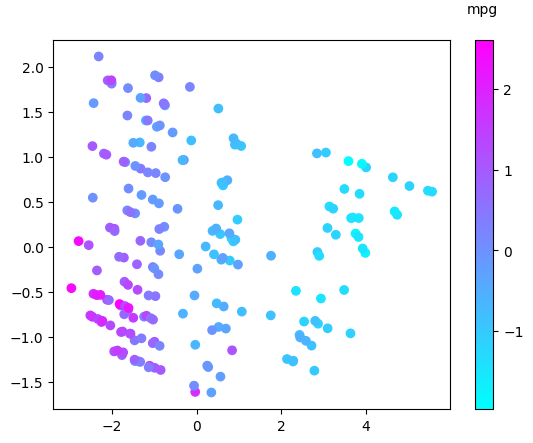

In [ ]:
#第一主成分と第二主成分の散布図(scoreの可視化)
#cmap:カラーマップ指定
#plt.get_cmap('cool');カラーマップの種類選択
#c = カラーバーのデータ選択(今回は目的変数)

plt.scatter(score.iloc[:,0], score.iloc[:,1] ,c = df_train_std['mpg'] , cmap = plt.get_cmap('cool'))
clb = plt.colorbar()

#labelpad;colorbarのラベル位置の横軸設定。
#負の値で左側に移動、自然数で右側に移動
#y;ラベル位置の縦軸設定
#y=1でcolorbarの上端とラベルの上端がかぶるためyh=1.1くらいがちょうどいい
#ラベルの反転
clb.set_label('mpg', labelpad=-30 , y = 1.1 , rotation=0)
plt.show()